# Unobserved components model with stochastic volatility - particle filter fit

Hopefully better than MCMC

# 1. Read data

In [1]:
import pandas as pd
from seminartools.data import read_inflation

df = read_inflation()
df

,Country Code,IMF Country Code,Country,yearmonth,inflation
23311,PRT,182,Portugal,1970-04-01,0.000000
21697,NZL,196,New Zealand,1970-04-01,0.015421
7708,DOM,243,Dominican Republic,1970-04-01,-0.001604
9062,FIN,172,Finland,1970-04-01,0.008333
13232,IRL,178,Ireland,1970-04-01,0.029871
...,...,...,...,...,...
4821,CAN,156,Canada,2023-01-01,0.006080
26740,SWE,144,Sweden,2023-01-01,0.014955
16098,KOR,542,"Korea, Rep.",2023-01-01,0.010538
10308,GBR,112,United Kingdom,2023-01-01,0.008814


/tmp/ipykernel_3474096/4071969969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df["pi"] = country_df["inflation"] * 100 # It is crucial to have inflation in %'s, otherwise GAMMA below is wrongly scaled.


<Axes: xlabel='yearmonth'>

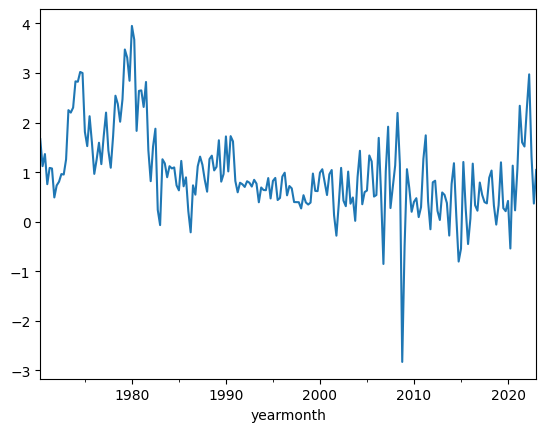

In [2]:
country_df = df[df["Country"] == "United States"]
country_df["pi"] = country_df["inflation"] * 100 # It is crucial to have inflation in %'s, otherwise GAMMA below is wrongly scaled.
country_df.set_index("yearmonth")["pi"].plot()

In [3]:
len(country_df)

212

# 2. Construct PF

$\pi_t = \tau_t + \eta_t$

$\tau_t = \tau_{t-1} + \epsilon_t$

$\ln \sigma_{\eta,t}^2 = \ln \sigma_{\eta,t-1}^2 + \nu_{\eta, t}$

$\ln \sigma_{\epsilon,t}^2 = \ln \sigma_{\epsilon,t-1}^2 + \nu_{\epsilon, t}$

In [4]:
import scipy
import numpy as np
from seminartools.models.base_model import BaseModel
from tqdm import trange
from numba import jit

# nu follows a normal distribution with variance gamma
GAMMA = 0.2

INIT_LNSETASQ = 0
INIT_LNSEPSILONSQ = 0

VAGUE_PRIOR_LNSETASQ_SIGMA = 3
VAGUE_PRIOR_LNSEPSILONSQ_SIGMA = 3
VAGUE_PRIOR_TAU_SIGMA = 1

# Unobserved Component Stochastic Volatility Particle Filter
class UCSVPF(BaseModel):
    def __init__(
        self,
        num_particles: int,
    ):
        self.num_particles = num_particles

    def fit(self, data: pd.DataFrame):
        """
        This model is not meant to be fitted to data every iteration using this method.
        Preferably, fit once on the entire dataset using `run_pf` and then
        figure out the historical predictions using the historical particles.
        """
        pass

    #@jit
    def run_pf(self, data: pd.DataFrame):
        """
        Run the particle filter on the data.
        """
        n = len(data)
        pi = data["pi"].values

        # Initial Particles
        X0 = np.zeros((self.num_particles, 3))
        X0[:, 0] = np.random.normal(size=self.num_particles, loc=1, scale=VAGUE_PRIOR_TAU_SIGMA)
        X0[:, 1] = np.random.normal(size=self.num_particles, loc=INIT_LNSETASQ, scale=VAGUE_PRIOR_LNSETASQ_SIGMA)
        X0[:, 2] = np.random.normal(size=self.num_particles, loc=INIT_LNSEPSILONSQ, scale=VAGUE_PRIOR_LNSEPSILONSQ_SIGMA)
        W0 = np.ones(self.num_particles) / self.num_particles

        X = np.zeros((n + 1, self.num_particles, 3))
        W = np.zeros((n + 1, self.num_particles))
        X[0, :, :] = X0
        W[0, :] = W0

        for t in trange(1, n + 1):
            # Step 1: predict and update
            W[t, :] = np.ones(self.num_particles) / self.num_particles
            for i in range(self.num_particles):
                X[t, i, 1] = np.random.normal(loc=X[t-1, i, 1], scale=np.sqrt(GAMMA))
                X[t, i, 2] = np.random.normal(loc=X[t-1, i, 2], scale=np.sqrt(GAMMA))
                X[t, i, 0] = np.random.normal(loc=X[t-1, i, 0], scale=np.sqrt(np.exp(X[t, i, 2])))

            mean_vals = X[t, :, 0]
            scale_vals = np.sqrt(np.exp(X[t, :, 1]))
            W[t, :] *= scipy.stats.norm.pdf(pi[t-1], loc=mean_vals, scale=scale_vals)
            W[t, :] = W[t, :] / np.sum(W[t, :])

            # Step 2: resample
            indices = np.random.choice(self.num_particles, size=self.num_particles, replace=True, p=W[t, :])
            X[t, :, :] = X[t, indices, :]

        self.X = X[1:, :, :]
        self.W = W[1:, :]
        self.EX = np.mean(self.X, axis=1)
        self.Esigmaeta = np.mean(np.sqrt(np.exp(self.X[:, :, 1])), axis=1)
        self.Esigmaepsilon = np.mean(np.sqrt(np.exp(self.X[:, :, 2])), axis=1)
        self.Meff = 1 / np.sum(self.W ** 2, axis=1)

    def predict(self, data: pd.DataFrame) -> pd.Series:
        """
        Predict the state at time t.
        """
        pass

model = UCSVPF(num_particles=1000)
model.run_pf(country_df)



100%|██████████| 212/212 [00:01<00:00, 178.91it/s]


Text(0.5, 1.0, 'Inflation and estimated latent process')

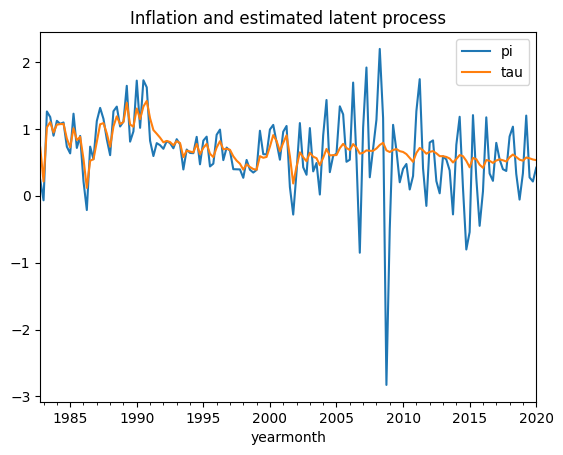

In [5]:
import matplotlib.pyplot as plt
merged = pd.concat(
    [
        country_df["pi"].reset_index(drop=True),
        pd.DataFrame(model.EX, columns=["tau", "lnsetasq", "lnsepsilonsq"]),
        pd.DataFrame(model.Esigmaeta, columns=["sigmaeta"]),
        pd.DataFrame(model.Esigmaepsilon, columns=["sigmaepsilon"]),
    ],
    axis = 1
).set_index(country_df["yearmonth"])
merged[["pi", "tau"]].iloc[50:200].plot()
plt.title("Inflation and estimated latent process")

<Axes: xlabel='yearmonth'>

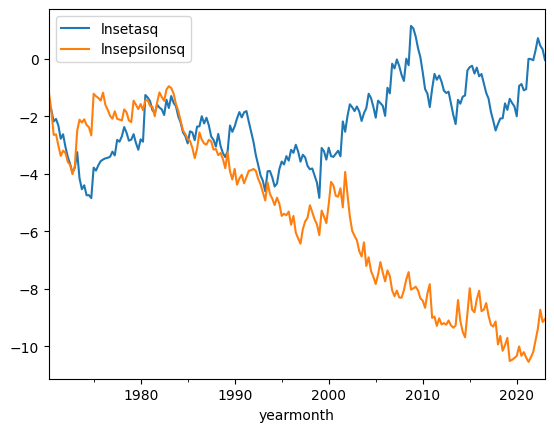

In [6]:
merged[["lnsetasq", "lnsepsilonsq"]].plot()

Text(0.5, 1.0, 'Estimated stochastic volatility')

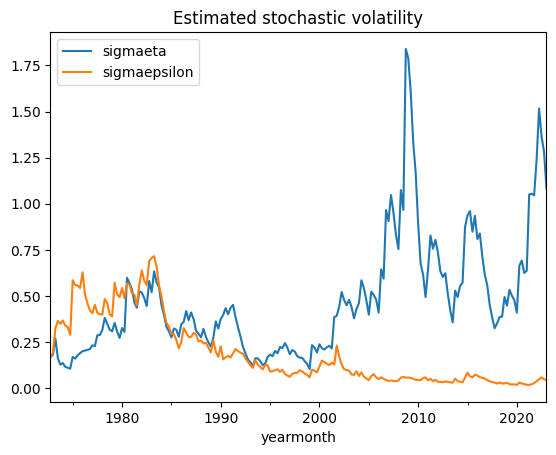

In [7]:
merged[["sigmaeta", "sigmaepsilon"]].iloc[10:].plot()
plt.title("Estimated stochastic volatility")

# Seasonality in inflation

In [8]:
CUTOFF_POINT = "2005-01-01"

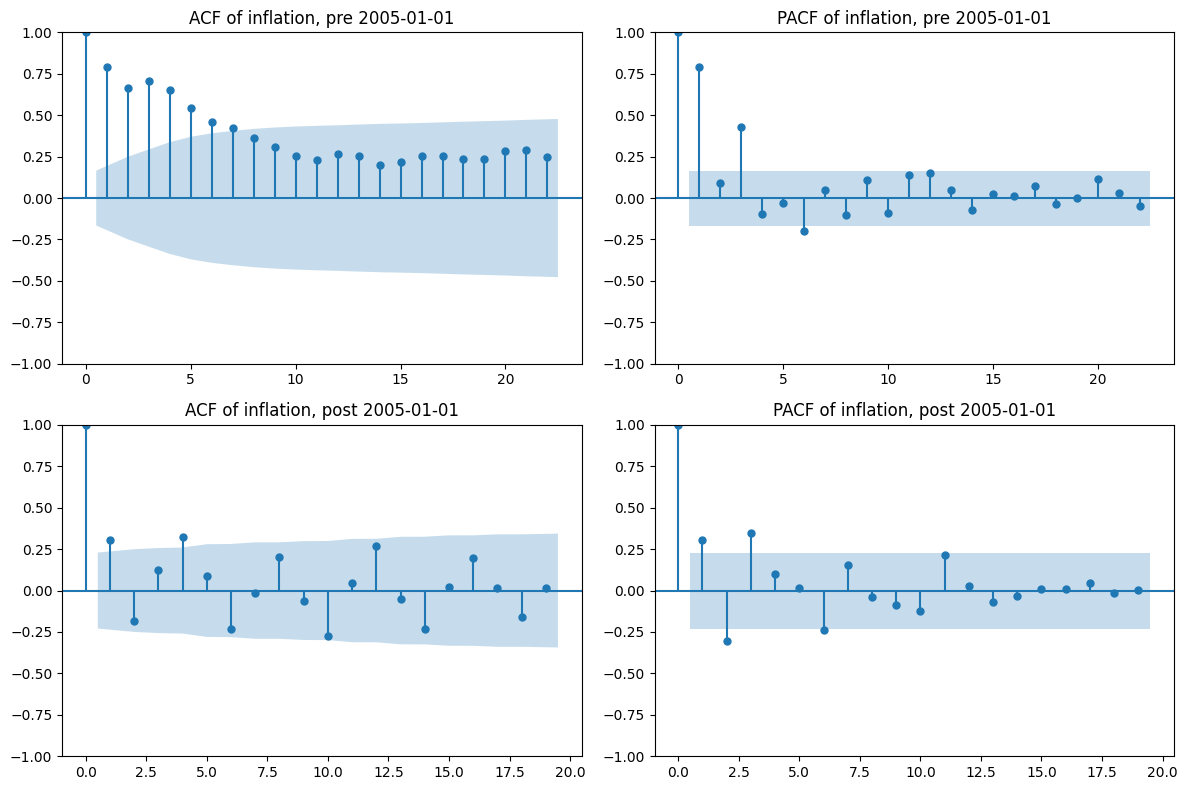

In [10]:
# plot acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(country_df.set_index("yearmonth").loc[:CUTOFF_POINT, "inflation"], ax=ax[0, 0])
ax[0, 0].set_title(f"ACF of inflation, pre {CUTOFF_POINT}")

plot_pacf(country_df.set_index("yearmonth").loc[:CUTOFF_POINT, "inflation"], ax=ax[0, 1])
ax[0, 1].set_title(f"PACF of inflation, pre {CUTOFF_POINT}")

plot_acf(country_df.set_index("yearmonth").loc[CUTOFF_POINT:, "inflation"], ax=ax[1, 0])
ax[1, 0].set_title(f"ACF of inflation, post {CUTOFF_POINT}")

plot_pacf(country_df.set_index("yearmonth").loc[CUTOFF_POINT:, "inflation"], ax=ax[1, 1])
ax[1, 1].set_title(f"PACF of inflation, post {CUTOFF_POINT}")

fig.tight_layout()
fig.savefig("../../Figures/pre_post_2005_us_acf_pacf.png")

why did stock watson not treat seasonality?

We improve upon SW: see UCSVSS